In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Loading the feature-enriched dataset
weekly_sales = pd.read_csv("D:\m5_demand_forecasting_project\outputs\weekly_sales.csv")

# Focusing on 1–3 high-volume SKUs for baseline demo
top3_skus = weekly_sales.groupby('item_id')['sales'].sum().sort_values(ascending=False).head(3).index.tolist()
weekly_sales = weekly_sales[weekly_sales['item_id'].isin(top3_skus)]

# Sorting for time series consistency
weekly_sales = weekly_sales.sort_values(by=['store_id', 'item_id', 'year_week'])

# Preview
print("Top 3 SKUs:", top3_skus)

Top 3 SKUs: ['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252']


---
**Key Findings:**

Loading the dataset, structured for rolling windows and lag analysis and taking top 3 high-volume SKUs for initiating Baseline Modelling.

---

In [2]:
# Creating Single Exponential Smoothing forecast
def compute_ses_metrics(df, skus, forecast_horizon=4):
    records = []

    for sku in skus:
        sku_df = df[df['item_id'] == sku]

        top_store = (
            sku_df.groupby('store_id')['sales']
                  .sum()
                  .idxmax()
        )

        ts = (
            sku_df.groupby('year_week')['sales']
                  .sum()
                  .sort_index()
                  .values
        )

        if len(ts) <= forecast_horizon:
            continue

        history = ts[:-forecast_horizon]
        actual  = ts[-forecast_horizon:]

        model    = SimpleExpSmoothing(history, initialization_method='heuristic').fit()
        forecast = model.forecast(forecast_horizon)

        mse   = mean_squared_error(actual, forecast)
        rmse  = np.sqrt(mse)
        smape = np.mean(
            2 * np.abs(forecast - actual)
            / (np.abs(actual) + np.abs(forecast))
        ) * 100

        diffs = np.diff(history)
        scale = np.mean(diffs**2) if len(diffs) > 0 else np.nan
        rmsse = np.sqrt(mse / scale) if scale and scale > 0 else np.nan

        records.append({
            'item_id':        sku,
            'store_id':       top_store,
            'rmse':           rmse,
            'smape':          smape,
            'rmsse':          rmsse,
            'volume':         history.sum()
        })

    res = pd.DataFrame(records)
    total_volume = res['volume'].sum()
    res['weight']  = res['volume'] / total_volume
    res['wrmsse']  = res['weight'] * res['rmsse']

    return res[['item_id', 'store_id', 'rmse', 'smape', 'rmsse', 'weight', 'wrmsse']]

# Run SES forecasting
ses_results = compute_ses_metrics(weekly_sales, top3_skus, forecast_horizon=4)
print("Single Exponential Smoothing (SES):\n", ses_results)

Single Exponential Smoothing (SES):
        item_id store_id        rmse      smape     rmsse    weight    wrmsse
0  FOODS_3_090     CA_3  478.616118  11.355116  0.329490  0.402402  0.132587
1  FOODS_3_586     TX_2  193.556996   5.418593  0.550059  0.370429  0.203758
2  FOODS_3_252     TX_2  124.239447   5.521609  0.500253  0.227169  0.113642


---
**Key Findings:**
1. Smooths past data with more weight on recent observations to capture short-term trends.
2. Evaluated using RMSE, sMAPE and WRMSSE matching Naïve setup for fair comparison.
---

In [3]:
# Creating Simple Moving Average forecast
def compute_moving_average_metrics(df, skus, forecast_horizon=4, ma_window=4):
    results = []

    for sku in skus:
        sku_df = df[df['item_id'] == sku]

        # Top store by total sales
        top_store = (
            sku_df.groupby('store_id')['sales']
                  .sum()
                  .idxmax()
        )

        # Weekly total sales across all stores, sorted
        ts = (
            sku_df.groupby('year_week')['sales']
                  .sum()
                  .sort_index()
                  .values
        )

        if len(ts) <= forecast_horizon:
            continue

        history = ts[:-forecast_horizon]
        actual  = ts[-forecast_horizon:]

        # Moving-average forecast
        window   = min(ma_window, len(history))
        ma_mean  = history[-window:].mean()
        forecast = np.repeat(ma_mean, forecast_horizon)

        # Metrics
        mse   = mean_squared_error(actual, forecast)
        rmse  = np.sqrt(mse)
        smape = np.mean(
            2 * np.abs(forecast - actual)
            / (np.abs(actual) + np.abs(forecast))
        ) * 100

        # RMSSE scale
        diffs = np.diff(history)
        scale = np.mean(diffs**2) if len(diffs) > 0 else np.nan
        rmsse = np.sqrt(mse / scale) if scale and scale > 0 else np.nan

        results.append({
            'item_id': sku,
            'store_id': top_store,
            'rmse': rmse,
            'smape': smape,
            'rmsse': rmsse,
            'volume': history.sum()
        })

    res = pd.DataFrame(results)
    total_volume = res['volume'].sum()
    res['weight']  = res['volume'] / total_volume
    res['wrmsse']  = res['weight'] * res['rmsse']

    return res[['item_id', 'store_id', 'rmse', 'smape', 'rmsse', 'weight', 'wrmsse']]

# Run Moving Average forecasting
ma_results = compute_moving_average_metrics(df=weekly_sales, skus=top3_skus, forecast_horizon=4, ma_window=4)
print("Simple Moving Average (MA):\n", ma_results)

Simple Moving Average (MA):
       item_id store_id        rmse     smape     rmsse    weight    wrmsse
0  FOODS_3_090     CA_3  229.584952  4.521313  0.158051  0.402402  0.063600
1  FOODS_3_586     TX_2  145.594471  4.249340  0.413757  0.370429  0.153268
2  FOODS_3_252     TX_2   55.269227  2.540993  0.222543  0.227169  0.050555


---
**Key Findings:**
1. Averages the last k = 4 points; window size trades off smoothness versus responsiveness.
2. RMSE, sMAPE and WRMSSE quickly gauge accuracy; great for steady trends but lags on sudden shifts.
---

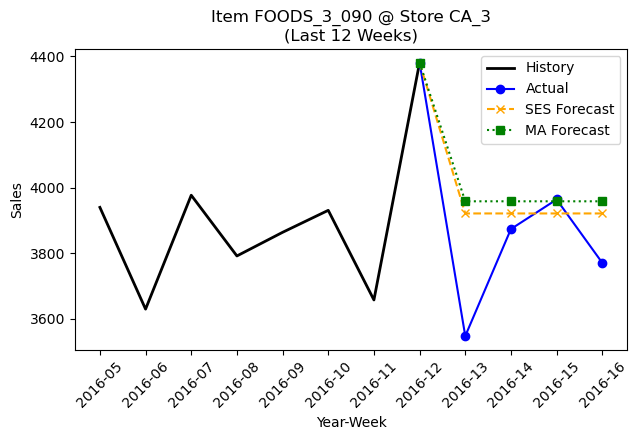

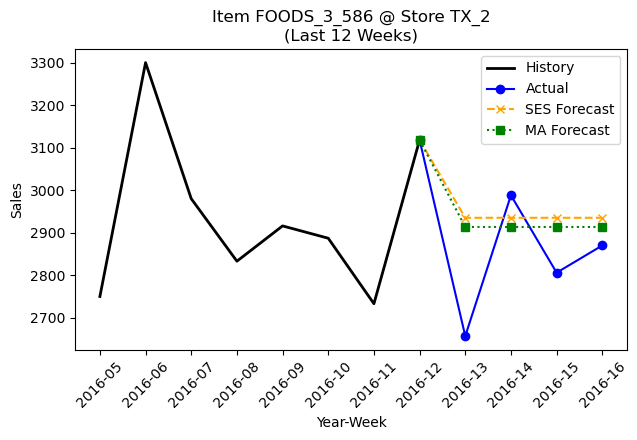

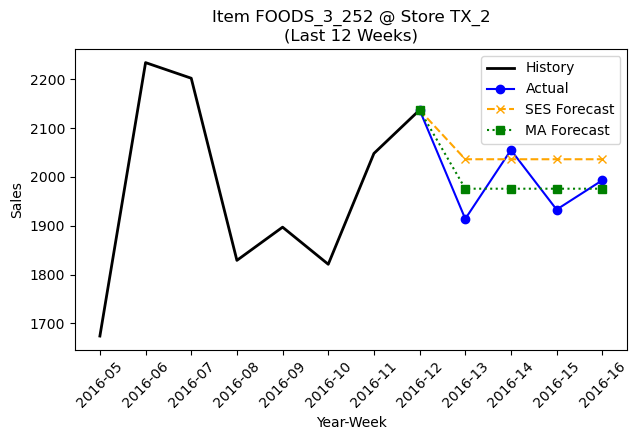

In [13]:
# Plotting Baseline Forecasts vs Actuals
forecast_horizon = 4
plot_window = 12
ma_window = 4   # how many past points to average for the MA forecast

for sku in top3_skus:
    sku_df = weekly_sales[weekly_sales['item_id'] == sku]

    # Identify top‐selling store for this SKU
    top_store = (
        sku_df.groupby('store_id')['sales']
              .sum()
              .idxmax()
    )

    # Aggregate weekly sales
    agg = (
        sku_df
        .groupby('year_week')['sales']
        .sum()
        .sort_index()
    )

    # Grab last `plot_window` weeks
    year_weeks = agg.index[-plot_window:]
    values     = agg.values[-plot_window:]

    if len(values) < plot_window:
        print(f"Skipping {sku} (not enough data)")
        continue

    # Split into history vs. actual
    hist_values = values[:-forecast_horizon]
    hist_weeks  = year_weeks[:-forecast_horizon]
    actual_vals = values[-forecast_horizon:]
    fcst_weeks  = year_weeks[-forecast_horizon:]

    # Last history point for extending lines
    last_val  = hist_values[-1]
    last_week = hist_weeks[-1]

    #  SES forecast
    ses_model    = SimpleExpSmoothing(hist_values, initialization_method="estimated").fit()
    ses_forecast = ses_model.forecast(forecast_horizon)
    ses_line_vals  = np.concatenate([[last_val], ses_forecast])
    ses_line_weeks = [last_week] + list(fcst_weeks)

    # Moving‐Average forecast
    window    = min(ma_window, len(hist_values))
    ma_mean   = hist_values[-window:].mean()
    ma_forecast   = np.repeat(ma_mean, forecast_horizon)
    ma_line_vals  = np.concatenate([[last_val], ma_forecast])
    ma_line_weeks = [last_week] + list(fcst_weeks)

    # Actuals
    actual_line_vals  = np.concatenate([[last_val], actual_vals])
    actual_line_weeks = [last_week] + list(fcst_weeks)

    # Plot
    plt.figure(figsize=(6.5, 4.5))
    plt.plot(hist_weeks,  hist_values,           label="History",      color="black", linewidth=2)
    plt.plot(actual_line_weeks, actual_line_vals, label="Actual",        color="blue",  marker="o")
    plt.plot(ses_line_weeks,     ses_line_vals,    label="SES Forecast",
             color="orange", linestyle="--", marker="x")
    plt.plot(ma_line_weeks,      ma_line_vals,     label=f"MA Forecast",
             color="green", linestyle=":", marker="s")
    plt.title(f"Item {sku} @ Store {top_store}\n(Last {plot_window} Weeks)")
    plt.xlabel("Year-Week")
    plt.ylabel("Sales")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

---
**Key Findings:**
1. MA forecast stays flat at the mean of the last 4 weeks and cannot adapt to upward or downward trends.
2. SES forecast captures the direction of change roughly, smoothing recent shifts but sometimes lagging sudden spikes.
---

In [5]:
# Merge SES and Moving Average results with custom suffixes
baseline_combined = pd.merge(
    ses_results, ma_results,
    on=["item_id", "store_id"],
    suffixes=("_ses", "_ma")
)

# Saving the combine results to CSV
baseline_combined.to_csv("D:\\m5_demand_forecasting_project\\outputs\\baseline_forecast_results.csv",index=False)

---
**Notebook Summary:** 

This notebook establishes baseline performance using Simple exponential smoothing (SES) and Moving Average (MA), with RMSE, sMAPE and WRMSSE metrics recorded. These baselines serve as essential reference points for subsequent ARIMA and Linear Regression modeling.

---